


\[
\begin{aligned}
r\,V_0(\delta)
&= \gamma \int \big[ V_0(\delta') - V_0(\delta) \big]\, dG(\delta') \\
&\quad + \lambda \int \!\left( \max\!\{ V_1(\delta,q') - P_1(q'),\, V_0(\delta) \} - V_0(\delta) \right) d\Phi_F(q') \\
&\quad + \rho \iint \!\left( \max\!\{ V_1(\delta,q') - P^{HH}(\delta,\delta';q'),\, V_0(\delta) \} - V_0(\delta) \right) dH_1(\delta',q')\\
\end{aligned}
\]

\[
\begin{aligned}
r\,\Delta V(\delta,q)
&= \delta\,q
\;+\; \gamma \int \!\big[\Delta V(\delta',q)-\Delta V(\delta,q)\big]\,dG(\delta')
\;+\; \mathcal L_q \Delta V(\delta,q) \\[2pt]
&\quad + \lambda F(0)\,\mathbf 1\!\{\delta \le \delta_1^*(q)\}
\Big(\Delta V(\delta_1^*(q),q)-\Delta V(\delta,q)\Big) \\[2pt]
&\quad + \lambda \int \mathbf 1\!\{\delta \ge \delta_0^*(q')\}
\Big(\Delta V(\delta,q')-\Delta V(\delta_0^*(q'),q')\Big)\, d\Phi_F(q') \\[2pt]
&\quad + \rho \int \frac{1}{2}\Big[\Delta V(\delta',q)-\Delta V(\delta,q)\Big]_+ \, dH_0(\delta') \\[2pt]
&\quad + \rho \iint \frac{1}{2}\Big[\Delta V(\delta,q')-\Delta V(\delta',q')\Big]_+ \, dH_1(\delta',q') \\
\end{aligned}
\]


In [18]:
import numpy as np
from dataclasses import dataclass

# ======================================================
#                 PRIMITIVES & GRIDS
# ======================================================

@dataclass
class Params:
    r: float
    gamma: float
    rho: float
    lam: float
    s: float          # target: sum(H1) + sum(F1q) = s
    f: float          # total flipper mass
    # quality generator (owners and F1)
    kappa0: float     # down rate coefficient: kappa(q)=kappa0*q
    nu0: float        # up rate: nu(q)=nu0 (const)
    delta_bar: float = 1.0

@dataclass
class Grids:
    delta: np.ndarray     # (Nd,)
    w: np.ndarray         # (Nd,), trapezoid weights sum to 1
    q: np.ndarray         # (Nq,)
    Nd: int
    Nq: int

def make_grids(Nd=121, Nq=15, delta_bar=1.0, q_min=0.85, q_max=1.15) -> Grids:
    d = np.linspace(0.0, delta_bar, Nd)
    w = np.ones(Nd) * (delta_bar/(Nd-1))
    w[0] *= 0.5; w[-1] *= 0.5
    w = w / w.sum()
    q = np.linspace(q_min, q_max, Nq)
    return Grids(delta=d, w=w, q=q, Nd=Nd, Nq=Nq)

# ======================================================
#               SHAPE / STACK HELPERS
# ======================================================

def flat(M):  # Fortran order (δ fast)
    return M.flatten(order='F')

def unflat(v, Nd, Nq):
    return v.reshape((Nd, Nq), order='F')

def stack_blocks(B0, B1):
    return np.concatenate([flat(B0), flat(B1)], axis=0)

def unstack_blocks(v, Nd, Nq):
    Nst = Nd*Nq
    B0 = unflat(v[:Nst], Nd, Nq)
    B1 = unflat(v[Nst:], Nd, Nq)
    return B0, B1

# ======================================================
#                 INTERPOLATION UTILS
# ======================================================

def interp2_separable(src_d, src_q, Z, dst_d, dst_q):
    """Separable 2D interp: first along δ for each q, then along q for each δ."""
    Nd_src, Nq_src = Z.shape
    Nd_dst, Nq_dst = len(dst_d), len(dst_q)
    tmp = np.zeros((Nd_dst, Nq_src))
    for k in range(Nq_src):
        tmp[:, k] = np.interp(dst_d, src_d, Z[:, k])
    out = np.zeros((Nd_dst, Nq_dst))
    for i in range(Nd_dst):
        out[i, :] = np.interp(dst_q, src_q, tmp[i, :])
    return out

def interp_vec(src_q, v, dst_q):
    return np.interp(dst_q, src_q, v)

# ======================================================
#         ACCEPTANCE SETS FROM CUTOFFS (PER LAYER)
# ======================================================

def acceptance_from_cutoffs(delta, d0_star, d1_star):
    Nd, Nq = len(delta), len(d0_star)
    sellF = np.zeros((Nd, Nq), dtype=float)  # owners sell to F if δ <= d1*(q)
    buyF  = np.zeros((Nd, Nq), dtype=float)  # nonowners buy from F if δ >= d0*(q)
    for k in range(Nq):
        sellF[:, k] = (delta <= d1_star[k]).astype(float)
        buyF[:,  k] = (delta >= d0_star[k]).astype(float)
    return sellF, buyF

# ======================================================
#           PARTNER MASSES (HH–HH) PER LAYER
# ======================================================

def partner_masses_layer(DV_k, H0_k, H1_k):
    order = np.argsort(DV_k, kind='mergesort')
    rank  = np.empty_like(order); rank[order] = np.arange(order.size)
    H0o, H1o, DVo = H0_k[order], H1_k[order], DV_k[order]
    cH1   = np.cumsum(H1o);  cH1DV = np.cumsum(H1o * DVo)
    cH0   = np.cumsum(H0o);  cH0DV = np.cumsum(H0o * DVo)
    totH0, totH0DV = cH0[-1], cH0DV[-1]
    M1_down = cH1[rank]
    S1_down = cH1DV[rank]
    prefH0   = np.where(rank>0, cH0[rank-1], 0.0)
    prefH0DV = np.where(rank>0, cH0DV[rank-1], 0.0)
    M0_up = totH0   - prefH0
    S0_up = totH0DV - prefH0DV
    return M0_up, M1_down, S0_up, S1_down

def build_partner_arrays_all_layers(DeltaV, H0, H1):
    Nd, Nq = DeltaV.shape
    M0 = np.zeros_like(DeltaV)
    M1 = np.zeros_like(DeltaV)
    S0 = np.zeros_like(DeltaV)
    S1 = np.zeros_like(DeltaV)
    for k in range(Nq):
        M0_up, M1_down, S0_up, S1_down = partner_masses_layer(DeltaV[:, k], H0[:, k], H1[:, k])
        M0[:, k] = M0_up
        M1[:, k] = M1_down
        S0[:, k] = S0_up
        S1[:, k] = S1_down
    return M0, M1, S0, S1

# ======================================================
#       QUALITY RATES (ARRAYS ON THE q-GRID)
# ======================================================

def quality_rates(gr: Grids, pr: Params):
    q = gr.q
    nu    = np.full(gr.Nq, pr.nu0, dtype=float)
    kappa = pr.kappa0 * q
    return nu, kappa

# ======================================================
#      GENERATOR A AND PRICE FLOWS φ UNDER FIXED POLICY
# ======================================================

def assemble_generator_and_phi(pr: Params, gr: Grids,
                               DeltaV, H0, H1,
                               d1_star, d0_star,
                               F0, F1q):
    Nd, Nq = gr.Nd, gr.Nq
    Nst = Nd*Nq
    r, gamma, rho, lam = pr.r, pr.gamma, pr.rho, pr.lam

    sellF, buyF = acceptance_from_cutoffs(gr.delta, d0_star, d1_star)
    M0, M1, S0, S1 = build_partner_arrays_all_layers(DeltaV, H0, H1)

    # prices from ΔV at cutoffs (linear interp on δ)
    def interp_by_delta(col, x):
        x = float(np.clip(x, gr.delta[0], gr.delta[-1]))
        j = int(np.searchsorted(gr.delta, x, side="left"))
        if j == 0:   return col[0]
        if j >= Nd:  return col[-1]
        x0,x1 = gr.delta[j-1], gr.delta[j]
        y0,y1 = col[j-1], col[j]
        w = (x - x0)/max(x1-x0, 1e-12)
        return (1-w)*y0 + w*y1

    P0 = np.zeros(Nq); P1 = np.zeros(Nq)
    for k in range(Nq):
        P0[k] = interp_by_delta(DeltaV[:, k], d1_star[k])  # owners' sell price
        P1[k] = interp_by_delta(DeltaV[:, k], d0_star[k])  # nonowners' buy price

    # HH–F hazards (status changes at same (δ,q))
    aF10 = lam * F0 * sellF                  # owner -> nonowner (sell to F)
    aF01 = lam * (F1q[None, :]) * buyF       # nonowner -> owner (buy from F at same q)

    # Price flows: HH–HH midpoint + HH–F prices
    phi0 = -0.5 * rho * (M1 * DeltaV + S1)  # nonowners pay midpoint
    phi1 =  0.5 * rho * (M0 * DeltaV + S0)  # owners receive midpoint
    phi1 += aF10 * (P0[None, :])            # owners receive P0 when selling to F
    phi0 += -aF01 * (P1[None, :])           # nonowners pay P1 when buying from F

    # Flow b: only owners receive δ*q
    b = np.zeros(2*Nst)
    b[Nst:] = flat(gr.delta[:, None] * gr.q[None, :])

    # Assemble A
    A = np.zeros((2*Nst, 2*Nst))
    Gamma = pr.gamma * np.outer(np.ones(Nd), gr.w)
    nu, kappa = quality_rates(gr, pr)

    def add(rows, cols, M):
        A[rows, cols] += M

    for k in range(Nq):
        r0 = k*Nd;      c0 = r0
        r1 = Nst + k*Nd; c1 = r1

        # taste redraw within block
        add(slice(r0, r0+Nd), slice(c0, c0+Nd), -gamma*np.eye(Nd) + Gamma)
        add(slice(r1, r1+Nd), slice(c1, c1+Nd), -gamma*np.eye(Nd) + Gamma)

        # status switches (same index)
        add(slice(r0, r0+Nd), slice(r1, r1+Nd), np.diag(aF01[:, k] + pr.rho*M1[:, k]))
        add(slice(r0, r0+Nd), slice(r0, r0+Nd), -np.diag(aF01[:, k] + pr.rho*M1[:, k]))
        add(slice(r1, r1+Nd), slice(r0, r0+Nd), np.diag(aF10[:, k] + pr.rho*M0[:, k]))
        add(slice(r1, r1+Nd), slice(r1, r1+Nd), -np.diag(aF10[:, k] + pr.rho*M0[:, k]))

        # quality operator on owner slab
        nu_k = nu[k]; kap_k = kappa[k]
        if k < Nq-1 and nu_k > 0:
            add(slice(r1, r1+Nd), slice(Nst+(k+1)*Nd, Nst+(k+2)*Nd), nu_k*np.eye(Nd))
            add(slice(r1, r1+Nd), slice(r1, r1+Nd), -nu_k*np.eye(Nd))
        if k > 0 and kap_k > 0:
            add(slice(r1, r1+Nd), slice(Nst+(k-1)*Nd, Nst+k*Nd), kap_k*np.eye(Nd))
            add(slice(r1, r1+Nd), slice(r1, r1+Nd), -kap_k*np.eye(Nd))

    phi = stack_blocks(phi0, phi1)
    return A, b, phi, P0, P1

# ======================================================
#             IMPLICIT HJB AND ADJOINT KFE
# ======================================================

def hjb_implicit(pr: Params, A, b, phi, V_old, dt=15.0, steps=60, tol=1e-10):
    K = (pr.r + 1.0/dt) * np.eye(A.shape[0]) - A
    rhs = b + phi
    V = V_old.copy()
    for _ in range(steps):
        V_new = np.linalg.solve(K, rhs + V/dt)
        if np.max(np.abs(V_new - V)) < tol:
            return V_new
        V = V_new
    return V

def kfe_adjoint_implicit(A, H_old, dt=15.0, steps=60, tol=1e-12):
    K = np.eye(A.shape[0]) - dt * A.T
    H = H_old.copy()
    for _ in range(steps):
        H_new = np.linalg.solve(K, H)
        if np.max(np.abs(H_new - H)) < tol:
            return H_new
        H = H_new
    return H

# ======================================================
#        FLIPPER VALUES (W0, W1(q)) WITH q-OPERATOR
# ======================================================

def quality_rates_only(gr: Grids, pr: Params):
    nu, kappa = quality_rates(gr, pr)
    return nu, kappa

def flipper_values(pr: Params, gr: Grids,
                   d1_star, d0_star, DeltaV,
                   H0, H1, P0, P1):
    Nd, Nq = gr.Nd, gr.Nq
    lam = pr.lam
    S1 = np.zeros(Nq); D0 = np.zeros(Nq)
    for k in range(Nq):
        S1[k] = float(H1[gr.delta <= d1_star[k], k].sum())
        D0[k] = float(H0[gr.delta >= d0_star[k], k].sum())

    nu, kappa = quality_rates_only(gr, pr)
    n = 1 + Nq
    K = np.zeros((n, n))
    rhs = np.zeros(n)

    # W0 row
    K[0, 0] = pr.r + lam * np.sum(S1)
    for k in range(Nq):
        K[0, 1+k] = - lam * S1[k]
        rhs[0]   += - lam * S1[k] * P0[k]

    # W1 rows (q-operator)
    for k in range(Nq):
        qsk = lam * D0[k]
        diag = pr.r + qsk + nu[k] + kappa[k]
        K[1+k, 1+k] = diag
        if k>0:      K[1+k, 1+(k-1)] = - kappa[k]
        if k<Nq-1:   K[1+k, 1+(k+1)] = - nu[k]
        K[1+k, 0] = - qsk
        rhs[1+k]  =   qsk * P1[k]

    W = np.linalg.solve(K, rhs)
    W0 = float(W[0])
    W1 = W[1:]
    DeltaW = W1 - W0
    return W0, W1, DeltaW

# ======================================================
#    FLIPPER INVENTORY F0, F1(q) FROM STATIONARY FLOWS
# ======================================================

def flipper_inventory_stationary(pr: Params, gr: Grids,
                                 d1_star, d0_star, H0, H1):
    Nd, Nq = gr.Nd, gr.Nq
    lam = pr.lam
    qb = np.zeros(Nq)  # owners -> F buys
    qs = np.zeros(Nq)  # F sells -> nonowners
    for k in range(Nq):
        qb[k] = lam * float(H1[gr.delta <= d1_star[k], k].sum())
        qs[k] = lam * float(H0[gr.delta >= d0_star[k], k].sum())

    nu, kappa = quality_rates(gr, pr)
    n = 1 + Nq
    K = np.zeros((n, n))
    rhs = np.zeros(n)

    # Rows 1..Nq: steady-state per layer k
    for k in range(Nq):
        row = 1 + k
        K[row, 0] = - qb[k]             # coeff on F0
        if k>0:      K[row, 1+(k-1)] = - nu[k-1]
        if k<Nq-1:   K[row, 1+(k+1)] = - kappa[k+1]
        K[row, 1+k] = (qs[k] + nu[k] + kappa[k])
        rhs[row] = 0.0

    # Row 0: mass constraint
    K[0, 0] = 1.0
    for k in range(Nq):
        K[0, 1+k] = 1.0
    rhs[0] = pr.f

    x = np.linalg.solve(K, rhs)
    F0 = float(x[0])
    F1q = x[1:]
    F1q = np.maximum(F1q, 0.0)
    tot = F0 + F1q.sum()
    if tot > 0:
        F0 *= pr.f/tot
        F1q *= pr.f/tot
    return F0, F1q

# ======================================================
#                CUTOFF FOC UPDATE (PER LAYER)
# ======================================================

def one_sided_slope_at(delta_grid, y, x_star, side):
    Nd = len(delta_grid)
    x_star = float(np.clip(x_star, delta_grid[0], delta_grid[-1]))
    j = int(np.searchsorted(delta_grid, x_star, side="left"))
    if side == "left":
        j = max(1, j)
        dy = y[j] - y[j-1]; dx = delta_grid[j] - delta_grid[j-1]
        return dy/max(dx, 1e-12)
    else:
        j = min(Nd-2, j)
        dy = y[j+1] - y[j]; dx = delta_grid[j+1] - delta_grid[j]
        return dy/max(dx, 1e-12)

def inverse_cdf_from_mass(cum, grid, target):
    target = float(np.clip(target, 0.0, cum[-1]))
    j = int(np.searchsorted(cum, target, side="left"))
    if j == 0: return float(grid[0])
    if j >= len(grid): return float(grid[-1])
    m0,m1 = cum[j-1], cum[j]
    x0,x1 = grid[j-1], grid[j]
    if (m1-m0) <= 1e-14: return 0.5*(x0+x1)
    w = (target - m0)/(m1-m0)
    return float(x0 + w*(x1-x0))

def cutoff_update_foc(gr: Grids, DeltaV, H0, H1, d1_star, d0_star, DeltaW, relax=0.25):
    Nd, Nq = gr.Nd, gr.Nq
    d1_new = d1_star.copy()
    d0_new = d0_star.copy()
    for k in range(Nq):
        H1_cum = np.cumsum(H1[:, k])
        H0_cum = np.cumsum(H0[:, k])
        DVk = DeltaV[:, k]
        m1 = one_sided_slope_at(gr.delta, DVk, d1_star[k], side="left")
        p0 = one_sided_slope_at(gr.delta, DVk, d0_star[k], side="right")
        i1 = int(np.argmin(np.abs(gr.delta - d1_star[k])))
        i0 = int(np.argmin(np.abs(gr.delta - d0_star[k])))
        h1_at = H1[i1, k] / max(gr.w[i1], 1e-12)
        h0_at = H0[i0, k] / max(gr.w[i0], 1e-12)
        DV_d1 = float(np.interp(d1_star[k], gr.delta, DVk))
        DV_d0 = float(np.interp(d0_star[k], gr.delta, DVk))
        S1_target = (DeltaW[k] - DV_d1) * h1_at / max(m1, 1e-12)
        D0_target = (DV_d0 - DeltaW[k]) * h0_at / max(p0, 1e-12)
        d1_raw = inverse_cdf_from_mass(H1_cum, gr.delta, S1_target)
        d0_raw = inverse_cdf_from_mass(H0_cum, gr.delta, H0_cum[-1] - D0_target)
        # relax and clamp
        d1_new[k] = (1.0 - relax)*d1_star[k] + relax*d1_raw
        d0_new[k] = (1.0 - relax)*d0_star[k] + relax*d0_raw
        d1_new[k] = float(np.clip(d1_new[k], gr.delta[0], gr.delta[-1]))
        d0_new[k] = float(np.clip(d0_new[k], gr.delta[0], gr.delta[-1]))
        if d1_new[k] > d0_new[k]:
            mid = 0.5*(d1_new[k] + d0_new[k])
            d1_new[k] = min(d1_new[k], mid)
            d0_new[k] = max(d0_new[k], mid)
    return d1_new, d0_new

# ======================================================
#                    MAIN SOLVER (WARM)
# ======================================================

def solve_model_quality(pr: Params, gr: Grids, init=None,
                        max_outer=200,
                        hjb_dt=15.0, hjb_steps=60,
                        kfe_dt=15.0, kfe_steps=60,
                        relax_cut=0.25, tol=1e-6, verbose=True, seed=0):
    np.random.default_rng(seed)
    Nd, Nq = gr.Nd, gr.Nq
    Nst = Nd*Nq

    # --- Initializations (warm start if provided) ---
    if init is not None:
        V0 = interp2_separable(init['gr'].delta, init['gr'].q, init['V0'], gr.delta, gr.q)
        V1 = interp2_separable(init['gr'].delta, init['gr'].q, init['V1'], gr.delta, gr.q)
        H0 = interp2_separable(init['gr'].delta, init['gr'].q, init['H0'], gr.delta, gr.q)
        H1 = interp2_separable(init['gr'].delta, init['gr'].q, init['H1'], gr.delta, gr.q)
        # normalize H and enforce owner share
        H = H0 + H1
        sH = H.sum();  H0 *= 1.0/max(sH,1e-12); H1 *= 1.0/max(sH,1e-12)
        d0_star = interp_vec(init['gr'].q, init['d0_star'], gr.q)
        d1_star = interp_vec(init['gr'].q, init['d1_star'], gr.q)
        F0 = float(init['F0'])
        F1q = np.interp(gr.q, init['gr'].q, init['F1q']) if 'F1q' in init else np.ones(Nq)*(pr.f/Nq)
        F1q = np.maximum(F1q, 0.0); totF = F0 + F1q.sum()
        if totF>0:
            F0 *= pr.f/totF; F1q *= pr.f/totF
    else:
        # Distributions: uniform across q, half owners/half nonowners
        base_pdf = (np.ones(Nd)/pr.delta_bar) * gr.w
        H0 = np.tile(0.5 * base_pdf[:, None] / Nq, (1, Nq))
        H1 = np.tile(0.5 * base_pdf[:, None] / Nq, (1, Nq))
        # Enforce owner share target approximately
        cur_H1 = H1.sum()
        target_H1 = max(1e-12, pr.s - 0.5*pr.f)
        if cur_H1 > 0:
            H1 *= target_H1 / cur_H1
            H0 *= (1.0 - target_H1) / max(H0.sum(), 1e-12)
        V0 = np.zeros((Nd, Nq))
        V1 = (gr.delta[:, None] * gr.q[None, :]) / (pr.r + pr.gamma + 1e-9)
        d0_star = np.full(Nq, float(np.quantile(gr.delta, 0.75)))
        d1_star = np.minimum(np.full(Nq, float(np.quantile(gr.delta, 0.20))), 0.8*d0_star)
        F0, F1q = flipper_inventory_stationary(pr, gr, d1_star, d0_star, H0, H1)

    V = stack_blocks(V0, V1)
    DeltaV = V1 - V0

    history = []
    for it in range(max_outer):
        # 1) HJB system under frozen acceptance
        A, b, phi, P0, P1 = assemble_generator_and_phi(pr, gr, DeltaV, H0, H1, d1_star, d0_star, F0, F1q)

        # 2) HJB implicit
        V_old = V.copy()
        V = hjb_implicit(pr, A, b, phi, V, dt=hjb_dt, steps=hjb_steps, tol=1e-10)
        V0, V1 = unstack_blocks(V, Nd, Nq)
        DeltaV = V1 - V0
        # Bellman residual (sup norm)
        bell = float(np.max(np.abs(((pr.r*np.eye(A.shape[0]) - A) @ V) - (b + phi))))

        # 3) Flipper values, then cutoff update (FOC)
        W0, W1, DeltaW = flipper_values(pr, gr, d1_star, d0_star, DeltaV, H0, H1, P0, P1)
        d1_star, d0_star = cutoff_update_foc(gr, DeltaV, H0, H1, d1_star, d0_star, DeltaW, relax=relax_cut)

        # 4) KFE adjoint, normalize, enforce owner share
        H_vec = stack_blocks(H0, H1)
        H_new = kfe_adjoint_implicit(A, H_vec, dt=kfe_dt, steps=kfe_steps, tol=1e-12)
        H_new = H_new / max(H_new.sum(), 1e-12)
        H0, H1 = unstack_blocks(H_new, Nd, Nq)
        target_H1 = max(1e-12, pr.s - F1q.sum())
        cur_H1 = H1.sum()
        if cur_H1 > 0:
            H1 *= target_H1 / cur_H1
        cur_H0 = H0.sum()
        if cur_H0 > 0:
            H0 *= (1.0 - target_H1) / cur_H0

        # 5) Update flipper inventory (stationary flows)
        F0, F1q = flipper_inventory_stationary(pr, gr, d1_star, d0_star, H0, H1)

        # Diagnostics
        cut_gap = float(np.max(np.maximum(d1_star - d0_star, 0.0)))
        if verbose:
            print(f"[it {it:03d}] ||Bell||={bell:.2e}  δ0*∈[{d0_star.min():.3f},{d0_star.max():.3f}]  "
                  f"δ1*∈[{d1_star.min():.3f},{d1_star.max():.3f}]  F0={F0:.5f}  sumF1={F1q.sum():.5f}  gap+={cut_gap:.2e}")
        history.append((bell, cut_gap, float(F0), float(F1q.sum())))

        if max(bell, cut_gap) < tol:
            break

    return dict(gr=gr, params=pr,
                V0=V0, V1=V1, DeltaV=DeltaV,
                H0=H0, H1=H1,
                d0_star=d0_star, d1_star=d1_star,
                P0=P0, P1=P1,
                F0=F0, F1q=F1q,
                history=history)

# ======================================================
#        MULTIGRID + HOMOTOPY CONTINUATION DRIVER
# ======================================================

def continuation_run():
    # ---- final (target) parameters ----
    pr_target = Params(
        r=0.04, gamma=0.08, rho=0.50, lam=2.50,
        s=0.70, f=0.010,
        kappa0=0.06,  # down rate ≈ 0.06*q
        nu0=0.04,     # up rate ≈ 0.04
        delta_bar=1.0
    )

    # ---- stages: (Nd, Nq, rho_scale, lam_scale, relax_cut, steps, dt) ----
    stages = [
        dict(Nd=101,  Nq=9,  rho_s=0.40, lam_s=0.60, relax=0.35, hjb_dt=16.0, kfe_dt=16.0, iters=300),
        dict(Nd=101, Nq=15, rho_s=0.70, lam_s=0.85, relax=0.25, hjb_dt=15.0, kfe_dt=15.0, iters=300),
        dict(Nd=101, Nq=21, rho_s=1.00, lam_s=1.00, relax=0.18, hjb_dt=15.0, kfe_dt=15.0, iters=300),
    ]

    init = None
    for s, st in enumerate(stages, 1):
        gr = make_grids(Nd=st['Nd'], Nq=st['Nq'], delta_bar=1.0, q_min=0.85, q_max=1.15)
        pr = Params(
            r=pr_target.r, gamma=pr_target.gamma,
            rho=pr_target.rho * st['rho_s'],
            lam=pr_target.lam * st['lam_s'],
            s=pr_target.s, f=pr_target.f,
            kappa0=pr_target.kappa0, nu0=pr_target.nu0,
            delta_bar=1.0
        )
        print(f"\n=== Stage {s}/{len(stages)}: Nd={gr.Nd}, Nq={gr.Nq}, rho={pr.rho:.3f}, lam={pr.lam:.3f}, relax={st['relax']} ===")
        out = solve_model_quality(
            pr, gr, init=init,
            max_outer=st['iters'],
            hjb_dt=st['hjb_dt'], hjb_steps=60,
            kfe_dt=st['kfe_dt'], kfe_steps=60,
            relax_cut=st['relax'], tol=5e-5, verbose=True, seed=0
        )
        # warm start for next stage
        init = dict(
            gr=gr,
            V0=out['V0'], V1=out['V1'],
            H0=out['H0'], H1=out['H1'],
            d0_star=out['d0_star'], d1_star=out['d1_star'],
            F0=out['F0'], F1q=out['F1q']
        )

    # final summary
    H1tot = float(out['H1'].sum()); F1tot = float(out['F1q'].sum())
    print("\n--- Final Summary ---")
    print("Owner share HH:", H1tot, "  Flipper inv:", F1tot,
          "  Target s:", pr_target.s, "  Total:", H1tot + F1tot)
    print("F0, sum F1:", float(out['F0']), F1tot)
    print("δ0* min/max:", float(out['d0_star'].min()), float(out['d0_star'].max()))
    print("δ1* min/max:", float(out['d1_star'].min()), float(out['d1_star'].max()))
    return out

# ======================================================
#                    SERIOUS RUN
# ======================================================

if __name__ == "__main__":
    _ = continuation_run()



=== Stage 1/3: Nd=101, Nq=9, rho=0.200, lam=1.500, relax=0.35 ===
[it 000] ||Bell||=3.99e-12  δ0*∈[0.488,0.488]  δ1*∈[0.130,0.130]  F0=0.00226  sumF1=0.00774  gap+=0.00e+00

=== Stage 2/3: Nd=101, Nq=15, rho=0.350, lam=2.125, relax=0.25 ===
[it 000] ||Bell||=6.47e-12  δ0*∈[0.366,0.470]  δ1*∈[0.098,0.098]  F0=0.00225  sumF1=0.00775  gap+=0.00e+00

=== Stage 3/3: Nd=101, Nq=21, rho=0.500, lam=2.500, relax=0.18 ===
[it 000] ||Bell||=4.64e-12  δ0*∈[0.317,0.459]  δ1*∈[0.080,0.080]  F0=0.00238  sumF1=0.00762  gap+=0.00e+00

--- Final Summary ---
Owner share HH: 0.6917127743124113   Flipper inv: 0.007616221223073936   Target s: 0.7   Total: 0.6993289955354852
F0, sum F1: 0.002383778776926065 0.007616221223073936
δ0* min/max: 0.3169163980216284 0.45918375515484366
δ1* min/max: 0.07995000000000001 0.07995000000000001



=== Stage 1/3: Nd=101, Nq=9, rho=0.200, lam=1.500, relax=0.35 ===
[it 000] ||Bell||=3.99e-12  δ0*∈[0.488,0.488]  δ1*∈[0.130,0.130]  F0=0.00226  sumF1=0.00774  gap+=0.00e+00

=== Stage 2/3: Nd=101, Nq=15, rho=0.350, lam=2.125, relax=0.25 ===
[it 000] ||Bell||=6.47e-12  δ0*∈[0.366,0.470]  δ1*∈[0.098,0.098]  F0=0.00225  sumF1=0.00775  gap+=0.00e+00

=== Stage 3/3: Nd=101, Nq=21, rho=0.500, lam=2.500, relax=0.18 ===
[it 000] ||Bell||=4.64e-12  δ0*∈[0.317,0.459]  δ1*∈[0.080,0.080]  F0=0.00238  sumF1=0.00762  gap+=0.00e+00

--- Final Summary ---
Owner share HH: 0.6917127743124113   Flipper inv: 0.007616221223073936   Target s: 0.7   Total: 0.6993289955354852
F0, sum F1: 0.002383778776926065 0.007616221223073936
δ0* min/max: 0.3169163980216284 0.45918375515484366
δ1* min/max: 0.07995000000000001 0.07995000000000001


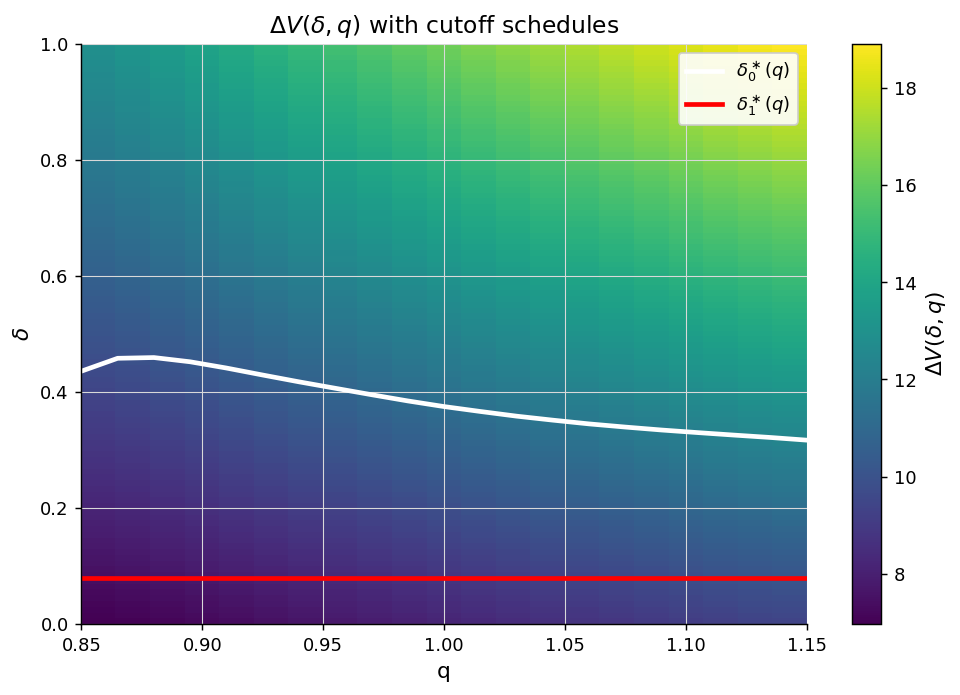

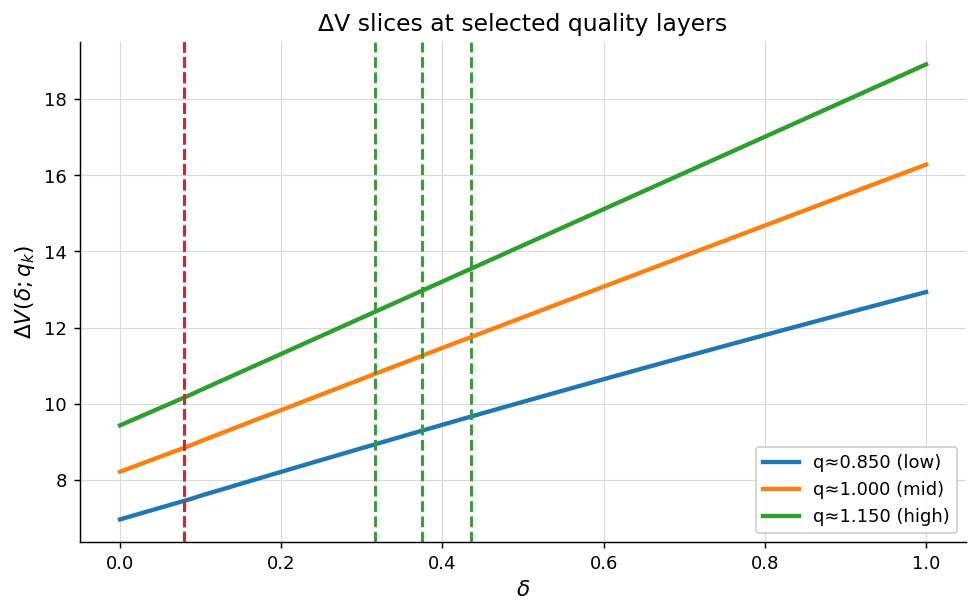

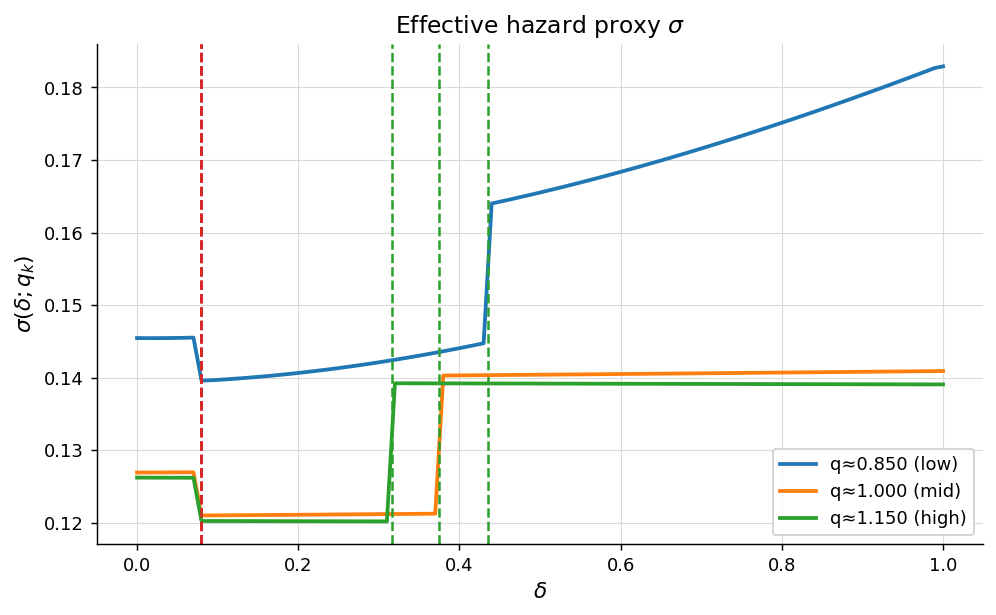

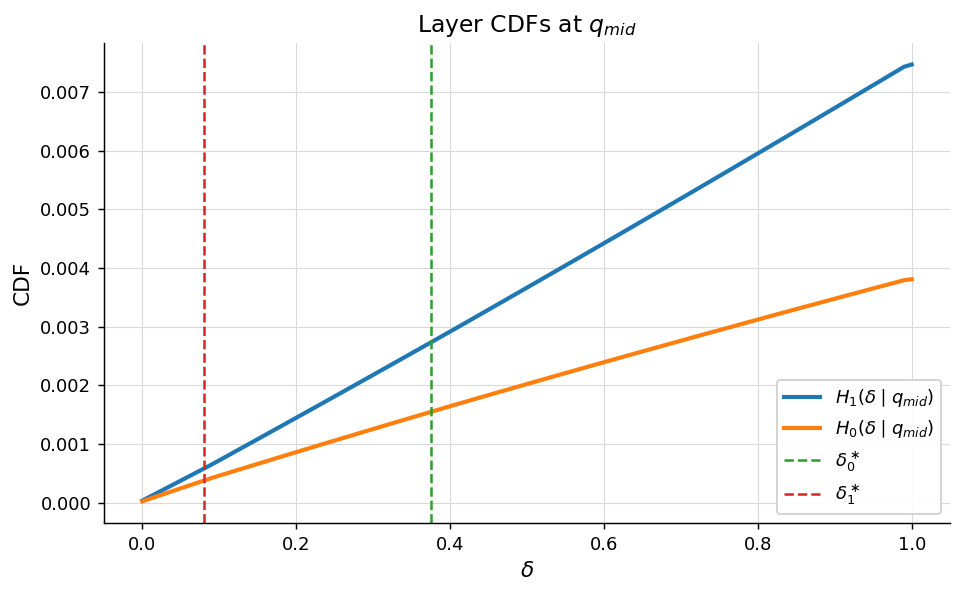

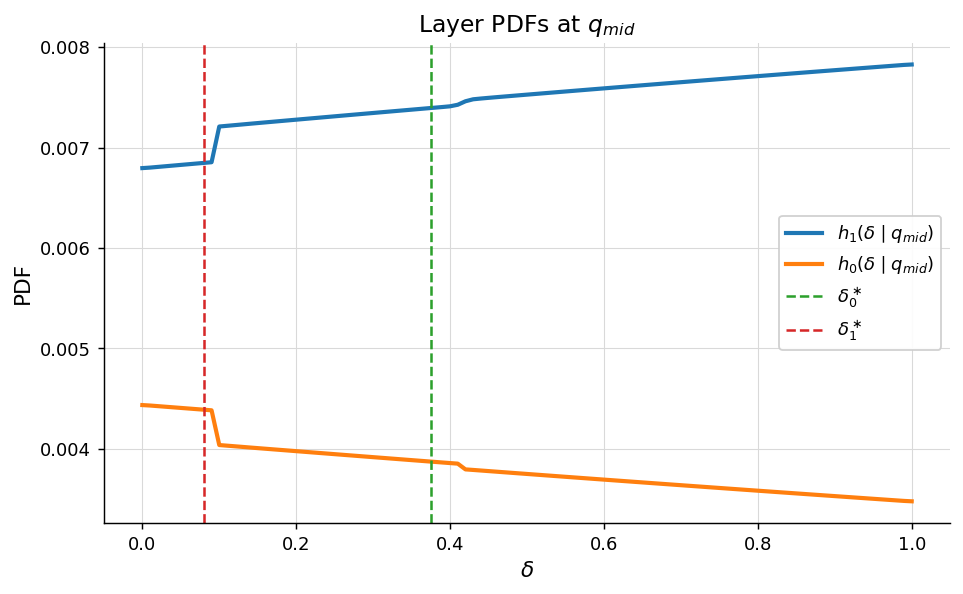

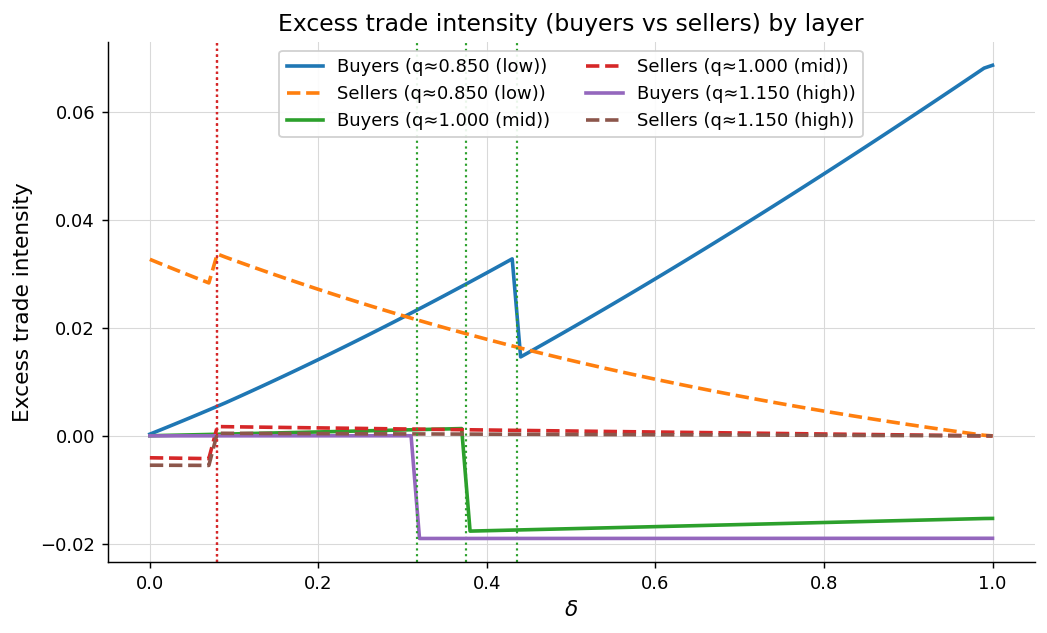

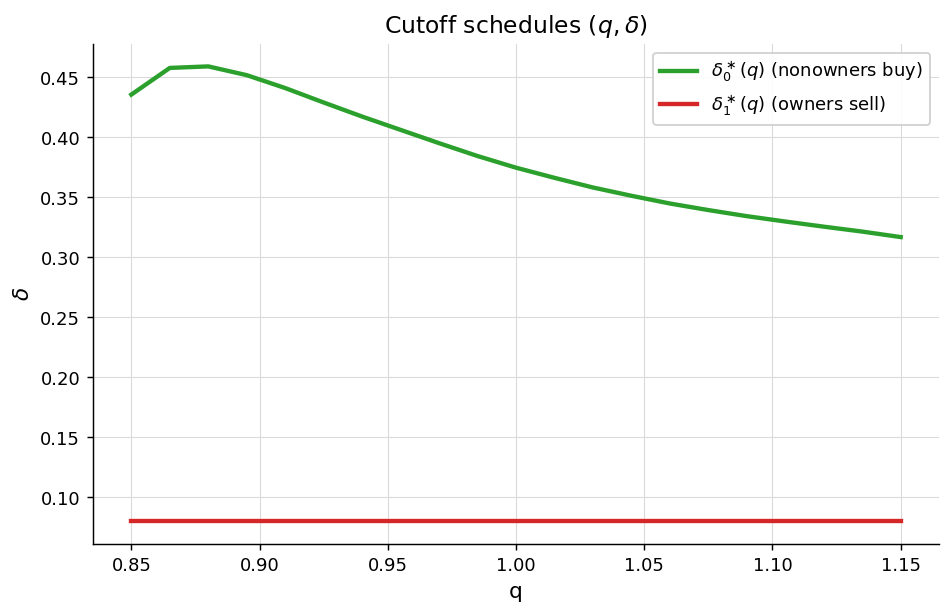

In [19]:
# ============================================================
# Run solver once more and plot results for the q-quality model
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import os

# ---------- Matplotlib aesthetic ----------
plt.rcParams.update({
    "figure.dpi": 130,
    "savefig.dpi": 130,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.color": "#D9D9D9",
    "grid.linestyle": "-",
    "grid.linewidth": 0.6,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.fancybox": True,
    "lines.linewidth": 2.0,
})

# ---------- helpers (CDF/PDF/etc) ----------
def _cdf_from_mass_layerwise(Htilde):
    return np.cumsum(Htilde, axis=0)

def _pdf_from_mass_layerwise(Htilde, wδ):
    eps = 1e-14
    return Htilde / np.clip(wδ[:, None], eps, None)

def _sigma_curve_layer(delta, H0_cdf_k, H1_cdf_k, F0, F1, params, d0_k, d1_k):
    r, gamma, lam, rho = params.r, params.gamma, params.lam, params.rho
    H0_1 = float(H0_cdf_k[-1])
    ind_right = (delta > d0_k).astype(float)
    ind_left  = (delta < d1_k).astype(float)
    return (r + gamma
            + lam * F1 * ind_right
            + lam * F0 * ind_left
            + 0.5 * rho * (H0_1 - H0_cdf_k)
            + 0.5 * rho * H1_cdf_k)

def _maybe_save(path):
    if path:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path, bbox_inches='tight')

def _pick_layers(q, how=('low','mid','high')):
    Nq = len(q)
    if isinstance(how, (list, tuple)):
        if all(isinstance(x, str) for x in how):
            idxs, labels = [], []
            for tag in how:
                if tag.lower() == 'low':
                    idxs.append(0); labels.append(f"q≈{q[0]:.3f} (low)")
                elif tag.lower() == 'mid':
                    m = Nq//2; idxs.append(m); labels.append(f"q≈{q[m]:.3f} (mid)")
                elif tag.lower() == 'high':
                    idxs.append(Nq-1); labels.append(f"q≈{q[-1]:.3f} (high)")
            return idxs, labels
        else:
            idxs = [int(np.clip(i, 0, Nq-1)) for i in how]
            labels = [f"q≈{q[i]:.3f}" for i in idxs]
            return idxs, labels
    return [0, Nq//2, len(q)-1], [f"q≈{q[0]:.3f} (low)", f"q≈{q[Nq//2]:.3f} (mid)", f"q≈{q[-1]:.3f} (high)"]

# ---------- plotting core ----------
def plot_all_quality(out_plot, params, selected_layers=('low','mid','high'),
                     save_dir=None, heatmap_cmap='viridis'):
    delta = out_plot['delta']
    # accept either 'wδ' or 'w'
    wδ    = out_plot['wδ'] if 'wδ' in out_plot else out_plot['w']
    q     = out_plot['q']
    ΔV    = out_plot['ΔV']
    H0̃    = out_plot['H0tilde']
    H1̃    = out_plot['H1tilde']
    d0    = out_plot['d0_star']
    d1    = out_plot['d1_star']
    F0    = out_plot['F0']
    F1    = out_plot['F1']

    H0t = H0̃; H1t = H1̃
    Nδ, Nq = ΔV.shape

    # CDF/PDF per layer
    H0_cdf_mat = _cdf_from_mass_layerwise(H0t)
    H1_cdf_mat = _cdf_from_mass_layerwise(H1t)
    h0_pdf_mat = _pdf_from_mass_layerwise(H0t, wδ)
    h1_pdf_mat = _pdf_from_mass_layerwise(H1t, wδ)

    # === A) Heatmap ΔV(δ,q) + cutoffs overlay ===
    plt.figure(figsize=(9.0, 5.8))
    extent = [q[0], q[-1], delta[0], delta[-1]]
    im = plt.imshow(ΔV, aspect='auto', origin='lower', extent=extent, cmap=heatmap_cmap)
    cbar = plt.colorbar(im); cbar.set_label(r'$\Delta V(\delta,q)$')
    plt.plot(q, d0, lw=2.6, color='white', label=r'$\delta_0^\ast(q)$')
    plt.plot(q, d1, lw=2.6, color='red',   label=r'$\delta_1^\ast(q)$')
    plt.xlabel('q'); plt.ylabel(r'$\delta$')
    plt.title(r'$\Delta V(\delta,q)$ with cutoff schedules')
    plt.legend(loc='upper right', frameon=True)
    _maybe_save(os.path.join(save_dir, 'Q_f1_heatmap_DeltaV_cutoffs.pdf') if save_dir else None)
    plt.show()

    # pick layers
    layer_idx, layer_labels = _pick_layers(q, selected_layers)

    # === B) ΔV(δ; q_k) lines ===
    plt.figure(figsize=(8.8, 5.0))
    for idx, lab in zip(layer_idx, layer_labels):
        plt.plot(delta, ΔV[:, idx], lw=2.4, label=lab)
        plt.axvline(d0[idx], color='tab:green', ls='--', lw=1.6)
        plt.axvline(d1[idx], color='tab:red',   ls='--', lw=1.6)
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$\Delta V(\delta; q_k)$')
    plt.title(r'ΔV slices at selected quality layers')
    plt.legend()
    _maybe_save(os.path.join(save_dir, 'Q_f2_DeltaV_layer_slices.pdf') if save_dir else None)
    plt.show()

    # === C) σ_k(δ) for selected layers ===
    plt.figure(figsize=(8.8, 5.0))
    for idx, lab in zip(layer_idx, layer_labels):
        sigma_k = _sigma_curve_layer(delta, H0_cdf_mat[:, idx], H1_cdf_mat[:, idx],
                                     F0, F1, params, d0[idx], d1[idx])
        plt.plot(delta, sigma_k, lw=2.1, label=lab)
        plt.axvline(d0[idx], color='tab:green', ls='--', lw=1.4)
        plt.axvline(d1[idx], color='tab:red',   ls='--', lw=1.4)
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$\sigma(\delta; q_k)$')
    plt.title(r'Effective hazard proxy $\sigma$')
    plt.legend()
    _maybe_save(os.path.join(save_dir, 'Q_f3_sigma_layers.pdf') if save_dir else None)
    plt.show()

    # === D) CDFs at q_mid ===
    mid = Nq // 2
    plt.figure(figsize=(8.4, 4.8))
    plt.plot(delta, H1_cdf_mat[:, mid], lw=2.3, label=r'$H_1(\delta\mid q_{mid})$')
    plt.plot(delta, H0_cdf_mat[:, mid], lw=2.3, label=r'$H_0(\delta\mid q_{mid})$')
    plt.axvline(d0[mid], color='tab:green', ls='--', lw=1.4, label=r'$\delta_0^\ast$')
    plt.axvline(d1[mid], color='tab:red',   ls='--', lw=1.4, label=r'$\delta_1^\ast$')
    plt.xlabel(r'$\delta$'); plt.ylabel('CDF')
    plt.title(r'Layer CDFs at $q_{mid}$')
    plt.legend()
    _maybe_save(os.path.join(save_dir, 'Q_f4_CDF_mid.pdf') if save_dir else None)
    plt.show()

    # === E) PDFs at q_mid ===
    plt.figure(figsize=(8.4, 4.8))
    plt.plot(delta, h1_pdf_mat[:, mid], lw=2.3, label=r'$h_1(\delta\mid q_{mid})$')
    plt.plot(delta, h0_pdf_mat[:, mid], lw=2.3, label=r'$h_0(\delta\mid q_{mid})$')
    plt.axvline(d0[mid], color='tab:green', ls='--', lw=1.4, label=r'$\delta_0^\ast$')
    plt.axvline(d1[mid], color='tab:red',   ls='--', lw=1.4, label=r'$\delta_1^\ast$')
    plt.xlabel(r'$\delta$'); plt.ylabel('PDF')
    plt.title(r'Layer PDFs at $q_{mid}$')
    plt.legend()
    _maybe_save(os.path.join(save_dir, 'Q_f5_PDF_mid.pdf') if save_dir else None)
    plt.show()

    # === F) Excess-trade intensity for selected layers ===
    plt.figure(figsize=(9.2, 5.2))
    for idx, lab in zip(layer_idx, layer_labels):
        buyers  = params.rho * H1_cdf_mat[:, idx] - params.lam * F1 * (delta > d0[idx]).astype(float)
        sellers = params.rho * (H0_cdf_mat[-1, idx] - H0_cdf_mat[:, idx]) - params.lam * F0 * (delta < d1[idx]).astype(float)
        plt.plot(delta, buyers,  lw=2.0, label=f'Buyers ({lab})')
        plt.plot(delta, sellers, lw=2.0, ls='--', label=f'Sellers ({lab})')
        plt.axvline(d0[idx], color='tab:green', ls=':', lw=1.2)
        plt.axvline(d1[idx], color='tab:red',   ls=':', lw=1.2)
    plt.xlabel(r'$\delta$'); plt.ylabel('Excess trade intensity')
    plt.title('Excess trade intensity (buyers vs sellers) by layer')
    plt.legend(ncol=2)
    _maybe_save(os.path.join(save_dir, 'Q_f6_excess_trade_layers.pdf') if save_dir else None)
    plt.show()

    # === G) Cutoff schedules in (q, δ) plane (explicit panel) ===
    plt.figure(figsize=(8.4, 5.0))
    plt.plot(q, d0, lw=2.4, color='tab:green', label=r'$\delta_0^\ast(q)$ (nonowners buy)')
    plt.plot(q, d1, lw=2.4, color='tab:red',   label=r'$\delta_1^\ast(q)$ (owners sell)')
    plt.xlabel('q'); plt.ylabel(r'$\delta$')
    plt.title(r'Cutoff schedules $(q,\delta)$')
    plt.legend()
    _maybe_save(os.path.join(save_dir, 'Q_f7_cutoff_schedules_qdelta.pdf') if save_dir else None)
    plt.show()

    # Optional: sparsity structure of A (if present)
    if 'A' in out_plot and out_plot['A'] is not None:
        plt.figure(figsize=(6.2, 6.0))
        plt.spy(out_plot['A'], markersize=0.3)
        plt.title('Generator A sparsity pattern')
        _maybe_save(os.path.join(save_dir, 'Q_f8_A_spy.pdf') if save_dir else None)
        plt.show()

# ---------- adapter: solver output -> plotting dict ----------
def adapt_for_plot(out_solver):
    gr = out_solver['gr']
    # F1 for plots expects a scalar; use total flipper owners mass
    F1_scalar = float(out_solver['F1q'].sum()) if 'F1q' in out_solver else float(out_solver.get('F1', 0.0))
    out_plot = {
        'delta': gr.delta,
        'wδ': gr.w,                 # also provide 'w' alias in case
        'w': gr.w,
        'q': gr.q,
        'ΔV': out_solver['DeltaV'],
        'H0tilde': out_solver['H0'],
        'H1tilde': out_solver['H1'],
        'd0_star': out_solver['d0_star'],
        'd1_star': out_solver['d1_star'],
        'F0': out_solver['F0'],
        'F1': F1_scalar,
        'A': out_solver.get('A', None)
    }
    return out_plot, out_solver['params']

# ---------- run once and plot ----------
if __name__ == "__main__":
    # Try to use the multi-stage serious run if available
    try:
        # Uses the continuation driver you have in the solver code
        out_final = continuation_run()
        params = out_final['params']
    except NameError:
        # Fallback: single-stage run with moderate grid if continuation_run is not defined
        try:
            # Assume solve_model_quality, Params, Grids, make_grids exist from your solver
            pr = Params(r=0.04, gamma=0.08, rho=0.5, lam=2.5, s=0.70, f=0.01,
                        kappa0=0.06, nu0=0.04, delta_bar=1.0)
            gr = make_grids(Nd=101, Nq=21, delta_bar=1.0, q_min=0.85, q_max=1.15)
            out_final = solve_model_quality(
                pr, gr,
                max_outer=300,
                hjb_dt=15.0, hjb_steps=60,
                kfe_dt=15.0, kfe_steps=60,
                relax_cut=0.25, tol=5e-5,
                verbose=True, seed=0
            )
            params = pr if 'params' not in out_final else out_final['params']
        except NameError as e:
            raise RuntimeError("Solver functions not found. Please run the solver code cell first.") from e

    # Adapt and plot
    out_plot, params_for_plot = adapt_for_plot(out_final)
    plot_all_quality(out_plot, params_for_plot,
                     selected_layers=('low','mid','high'),
                     save_dir=None, heatmap_cmap='viridis')
